<a href="https://www.kaggle.com/code/burakaka/brain-tumor-classification?scriptVersionId=213559456" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Rescaling,Dense,RandomTranslation,RandomBrightness,RandomWidth,RandomHeight,RandomContrast, Conv2D,Input, MaxPooling2D, Flatten, GlobalAveragePooling2D,Dropout,Rescaling,RandomFlip,RandomRotation,RandomZoom,Reshape
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB7
import tensorflow as tf

In [2]:
data_dir="/kaggle/input/brain-tumor-mri-data/brain-tumor-mri-dataset"

In [3]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, 
    subset="training", 
    seed=123,  
    image_size=(224, 224),
    batch_size=32
)

Found 7153 files belonging to 4 classes.
Using 5723 files for training.


In [4]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # %20 test seti
    subset="validation",  # Validation seti
    seed=123,  # Aynı seed kullanılmalı
    image_size=(224,224),
    batch_size=32
)

Found 7153 files belonging to 4 classes.
Using 1430 files for validation.


In [5]:
train_dataset.class_names

['glioma', 'meningioma', 'notumor', 'pituitary']

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

# Model ağırlıklarını kaydetmek için
checkpoint = ModelCheckpoint(
    filepath='best_model_efficientnetb7.keras',  
    monitor='val_accuracy',       
    save_best_only=True,       
    mode='max',                
    verbose=1
)

# Öğrenme oranını dinamik olarak azaltmak için
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',      
    factor=0.5,
    patience=3,
    min_lr=1e-6,              
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True,
    verbose=1
)


In [7]:
data_augmentation = Sequential([
    
    RandomFlip("horizontal"),   
    RandomRotation(0.3),        
    RandomZoom(0.2),            
    RandomContrast(0.2),        
    RandomHeight(0.2),          
    RandomWidth(0.2),           
])

In [8]:
base_model = EfficientNetB7(
    input_shape=(224, 224, 3),  # Giriş şekli
    include_top=False,          # Son sınıflandırma katmanlarını dahil etmiyoruz
    weights='imagenet'          # ImageNet ağırlıkları ile önceden eğitilmiş model
)

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
len(base_model.layers)

814

In [10]:
for layer in base_model.layers[:805]:  
    layer.trainable = False

In [11]:
base_model.summary()

Model: "efficientnetb7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      2,048 │ block1a_se_excit

 Total params: 64,097,687 (244.51 MB)

 Trainable params: 4,720,640 (18.01 MB)

 Non-trainable params: 59,377,047 (226.51 MB)

In [12]:
model = Sequential([
    InputLayer(shape=(224,224,3)),
# Veri artırma
    base_model,  # Önceden eğitilmiş model
    GlobalAveragePooling2D(),  # Ortalamalı havuzlama
    Dense(1024, activation='relu'),  # Yeni katman
    Dropout(0.3),
    Dense(len(train_dataset.class_names), activation='softmax')  # Kendi sınıflarınıza göre
])

In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb7 (Functional)     │ (None, 7, 7, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,622,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,724,251 (254.53 MB)

 Trainable params: 7,347,204 (28.03 MB)

 Non-trainable params: 59,377,047 (226.51 MB)

In [14]:

for image,label in train_dataset.take(1):
  print(label)  # so sparse_cross_entropy is used

tf.Tensor([1 1 1 1 0 0 3 2 3 2 1 0 1 3 0 2 2 3 2 0 1 0 2 1 0 2 2 0 2 3 2 2], shape=(32,), dtype=int32)


In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[checkpoint,reduce_lr,early_stopping]  
)


Epoch 1/100


I0000 00:00:1734454886.350444      97 service.cc:145] XLA service 0x7d75e8023ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734454886.350498      97 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734454886.350503      97 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734454984.832920      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.7848 - loss: 0.5657
Epoch 1: val_accuracy improved from -inf to 0.90839, saving model to best_model_efficientnetb7.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 308s 998ms/step - accuracy: 0.7852 - loss: 0.5648 - val_accuracy: 0.9084 - val_loss: 0.2470 - learning_rate: 0.0010
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.9202 - loss: 0.2143
Epoch 2: val_accuracy improved from 0.90839 to 0.91678, saving model to best_model_efficientnetb7.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 64s 360ms/step - accuracy: 0.9203 - loss: 0.2143 - val_accuracy: 0.9168 - val_loss: 0.2695 - learning_rate: 0.0010
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9406 - loss: 0.1693
Epoch 3: val_accuracy improved from 0.91678 to 0.95105, saving model to best_model_efficientnetb7.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 65s 365ms/step - accuracy: 0.9406 - loss: 0.1692 - val_accuracy: 0.9510 - val_loss: 0.1571 - learning_rate: 0.0010
Epo

In [21]:
from tensorflow.keras.models import load_model



45/45 ━━━━━━━━━━━━━━━━━━━━ 33s 370ms/step - accuracy: 0.7789 - loss: 1.3544


[1.2887929677963257, 0.785314679145813]

In [24]:
model.evaluate(val_dataset)

45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 267ms/step - accuracy: 0.9793 - loss: 0.1387


[0.10385408997535706, 0.9783216714859009]

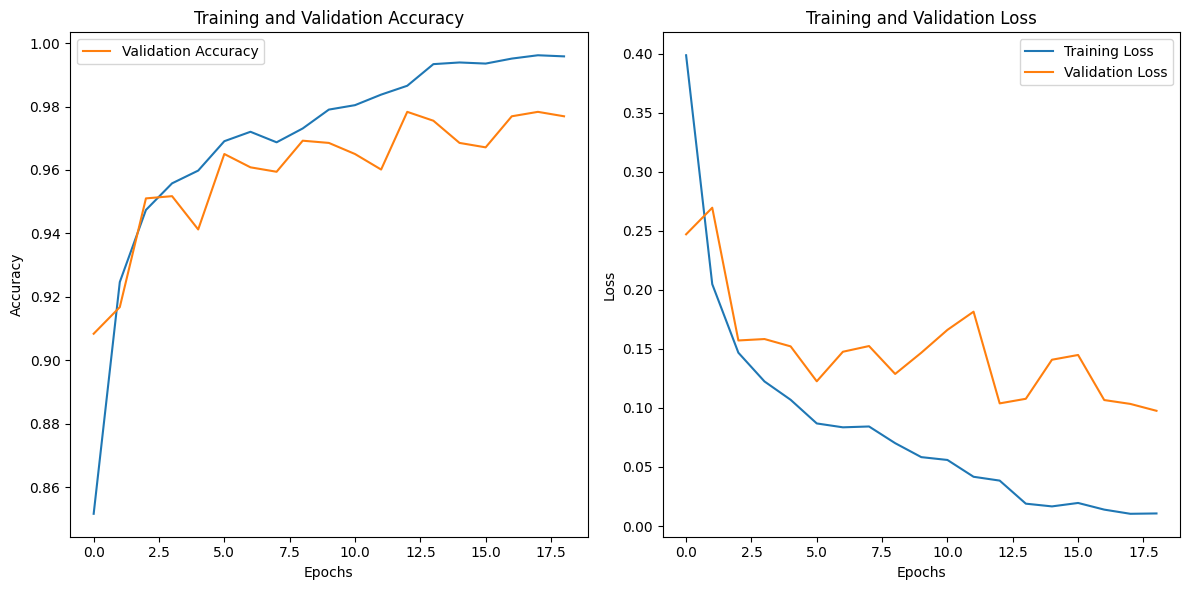

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()